<h3> Recuperação dos dados na base </h3>

In [1]:
df = spark.read.format('com.mongodb.spark.sql.DefaultSource').load()

<h3> Separação das vagas por tecnologia </h3>

In [2]:
from pyspark.sql.functions import desc

jobs_count_by_category = df.groupBy('tag').count().orderBy(desc('count'))

jobs_count_by_category.collect()

[Row(tag='java', count=3687),
 Row(tag='javascript', count=3363),
 Row(tag='.net', count=2492),
 Row(tag='php', count=1786),
 Row(tag='python', count=985),
 Row(tag='ruby', count=558)]

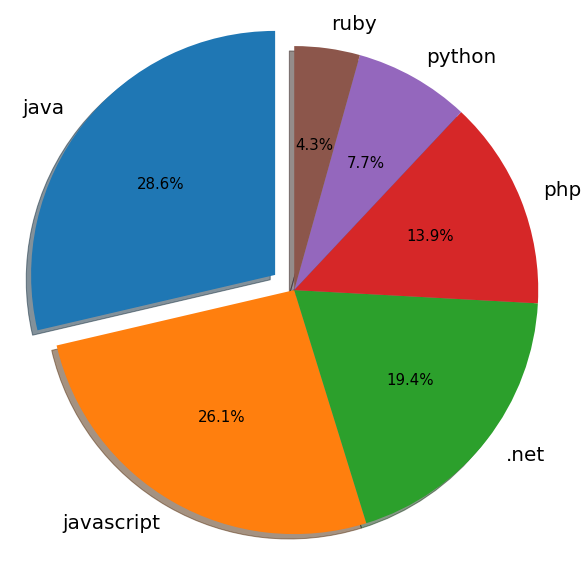

In [3]:
import matplotlib.pyplot as plt
 
# Data to plot
categories = jobs_count_by_category.rdd.map(lambda row: row['tag']).collect()
values = jobs_count_by_category.rdd.map(lambda row: row['count']).collect()
explode = (0.1, 0, 0, 0, 0, 0)  # explode 1st slice
 
# Plot
fig1, ax1 = plt.subplots(figsize=(8, 8))

patches, texts, autotexts = ax1.pie(values, explode=explode, labels=categories, autopct='%1.1f%%', shadow=True, startangle=90)

#set the labels font size
[_.set_fontsize(20) for _ in texts]

[_.set_fontsize(15) for _ in autotexts]

ax1.axis('equal')

plt.tight_layout()
plt.show()

<h3> Separação das vagas por estado </h3>

In [4]:
jobs_count_by_state = df.groupBy('state_short').count().orderBy(desc('count'))

In [5]:
jobs_count_by_state.collect()

[Row(state_short='SP', count=6277),
 Row(state_short='RS', count=1416),
 Row(state_short='PR', count=1170),
 Row(state_short='SC', count=1004),
 Row(state_short='RJ', count=926),
 Row(state_short='MG', count=923),
 Row(state_short='DF', count=333),
 Row(state_short='PE', count=205),
 Row(state_short='CE', count=129),
 Row(state_short='AM', count=78),
 Row(state_short='ES', count=57),
 Row(state_short='GO', count=53),
 Row(state_short='TO', count=51),
 Row(state_short='BA', count=47),
 Row(state_short='SE', count=44),
 Row(state_short='RN', count=42),
 Row(state_short='MT', count=36),
 Row(state_short='PA', count=36),
 Row(state_short='MS', count=21),
 Row(state_short='PB', count=9),
 Row(state_short='AL', count=6),
 Row(state_short='RO', count=3),
 Row(state_short='MA', count=3),
 Row(state_short='PI', count=1),
 Row(state_short='AC', count=1)]

In [6]:
# Data to plot
states_rdd = jobs_count_by_state.rdd.map(lambda row: row['state_short'])
values_rdd = jobs_count_by_state.rdd.map(lambda row: row['count'])

In [7]:
states = states_rdd.collect()
values = values_rdd.collect()

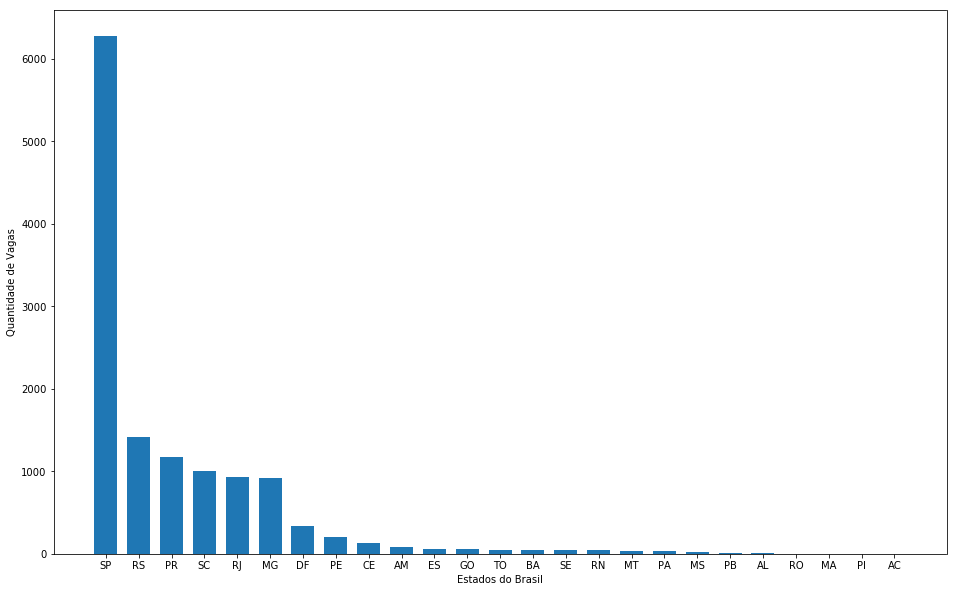

In [8]:
import numpy as np

x_pos = np.arange(len(states))

fig1, ax1 = plt.subplots(figsize=(16, 10))

ax1.bar(x_pos, values, 0.7, align='center')
plt.xticks(x_pos, states)
plt.xlabel('Estados do Brasil')
plt.ylabel('Quantidade de Vagas')
plt.show()

### Sumarização das vagas por estado

In [9]:
states = states[0:7]
values = values[0:7]

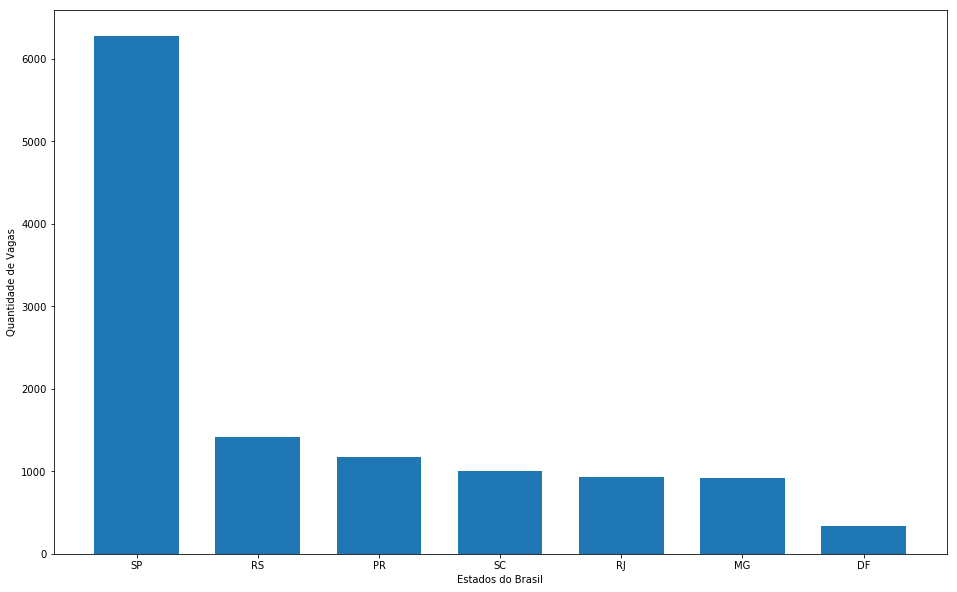

In [10]:
x_pos = np.arange(len(states))

fig1, ax1 = plt.subplots(figsize=(16, 10))

ax1.bar(x_pos, values, 0.7, align='center')
plt.xticks(x_pos, states)
plt.xlabel('Estados do Brasil')
plt.ylabel('Quantidade de Vagas')
plt.show()

In [11]:
saopaulo_and_others_df = jobs_count_by_state.where('count > 300')

saopaulo_and_others_rdd = saopaulo_and_others_df.rdd.map(lambda row: (row['state_short'], row['count']) \
                                                      if row['state_short'] == 'SP' else ('outros_estados', row['count']))

In [12]:
saopaulo_and_others_rdd.collect()

[('SP', 6277),
 ('outros_estados', 1416),
 ('outros_estados', 1170),
 ('outros_estados', 1004),
 ('outros_estados', 926),
 ('outros_estados', 923),
 ('outros_estados', 333)]

In [13]:
saopaulo_and_others_reduced_rdd = saopaulo_and_others_rdd.reduceByKey(lambda x, y: x + y)

In [14]:
saopaulo_and_others_reduced_rdd.collect()

[('outros_estados', 5772), ('SP', 6277)]

In [15]:
states = saopaulo_and_others_reduced_rdd.map(lambda x: x[0]).collect()
values = saopaulo_and_others_reduced_rdd.map(lambda x: x[1]).collect()

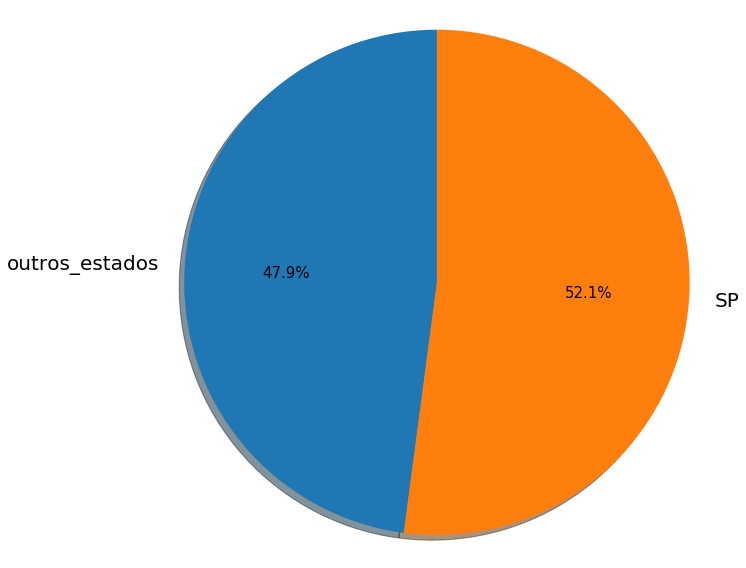

In [16]:
fig1, ax1 = plt.subplots(figsize=(8, 8))

patches, texts, autotexts = ax1.pie(values, labels=states, autopct='%1.1f%%', shadow=True, startangle=90)

# Configura o tamanho da fonte do gráfico
[_.set_fontsize(20) for _ in texts]

[_.set_fontsize(15) for _ in autotexts]

ax1.axis('equal')

plt.tight_layout()
plt.show()

<h3> Limpeza dos títulos das vagas </h3>

<p> Agora será necessário fazer uma limpeza dos títulos das vagas de trabalho, removendo caracteres especiais, pontos, vírgulas e outras coisas que não sejam letras ou números </p>

In [17]:
import re

from pyspark.sql.types import Row

stops = ["em","and","e","de","a","acerca","adeus","agora","ainda","alem","algo","algumas","alguns","ali","além","ambas","ambos",
         "ano","anos","antes","ao","aonde","aos","apenas","apoio","apontar","apos","após","aquela","aquelas","aquele","aqueles",
         "aqui","aquilo","as","assim","através","atrás","até","aí","baixo","bastante","bem","boa","boas","bom","bons","breve",
         "cada","caminho","catorze","cedo","cento","certamente","certeza","cima","cinco","coisa","com","como","comprido",
         "conhecido","conselho","contra","contudo","corrente","cuja","cujas","cujo","cujos","custa","cá","da","daquela","daquelas",
         "daquele","daqueles","dar","das","de","debaixo","dela","delas","dele","deles","demais","dentro","depois","desde",
         "desligado","dessa","dessas","desse","desses","desta","destas","deste","destes","deve","devem","deverá","dez","dezanove",
         "dezasseis","dezassete","dezoito","dia","diante","direita","dispoe","dispoem","diversa","diversas","diversos","diz",
         "dizem","dizer","do","dois","dos","doze","duas","durante","dá","dão","dúvida","e","ela","elas","ele","eles","em","embora",
         "enquanto","entao","entre","então","era","eram","essa","essas","esse","esses","esta","estado","estamos","estar","estará",
         "estas","estava","estavam","este","esteja","estejam","estejamos","estes","esteve","estive","estivemos","estiver",
         "estivera","estiveram","estiverem","estivermos","estivesse","estivessem","estiveste","estivestes","estivéramos",
         "estivéssemos","estou","está","estás","estávamos","estão","eu","exemplo","falta","fará","favor","faz","fazeis","fazem",
         "fazemos","fazer","fazes","fazia","faço","fez","fim","final","foi","fomos","for","fora","foram","forem","forma","formos",
         "fosse","fossem","foste","fostes","fui","fôramos","fôssemos","geral","grande","grandes","grupo","ha","haja","hajam",
         "hajamos","havemos","havia","hei","hoje","hora","horas","houve","houvemos","houver","houvera","houveram","houverei",
         "houverem","houveremos","houveria","houveriam","houvermos","houverá","houverão","houveríamos","houvesse","houvessem",
         "houvéramos","houvéssemos","há","hão","iniciar","inicio","ir","irá","isso","ista","iste","isto","já","lado","lhe","lhes",
         "ligado","local","logo","longe","lugar","lá","maior","maioria","maiorias","mais","mal","mas","me","mediante","meio",
         "menor","menos","meses","mesma","mesmas","mesmo","mesmos","meu","meus","mil","minha","minhas","momento","muito","muitos",
         "máximo","mês","na","nada","nao","naquela","naquelas","naquele","naqueles","nas","nem","nenhuma","nessa","nessas","nesse",
         "nesses","nesta","nestas","neste","nestes","no","noite","nome","nos","nossa","nossas","nosso","nossos","nova","novas",
         "nove","novo","novos","num","numa","numas","nunca","nuns","não","nível","nós","número","o","obra","obrigada","obrigado",
         "oitava","oitavo","oito","onde","ontem","onze","os","ou","outra","outras","outro","outros","para","parece","parte",
         "partir","paucas","pegar","pela","pelas","pelo","pelos","perante","perto","pessoas","pode","podem","poder","poderá",
         "podia","pois","ponto","pontos","por","porque","porquê","portanto","posição","possivelmente","posso","possível","pouca",
         "pouco","poucos","povo","primeira","primeiras","primeiro","primeiros","promeiro","propios","proprio","própria","próprias",
         "próprio","próprios","próxima","próximas","próximo","próximos","puderam","pôde","põe","põem","quais","qual","qualquer",
         "quando","quanto","quarta","quarto","quatro","que","quem","quer","quereis","querem","queremas","queres","quero","questão",
         "quieto","quinta","quinto","quinze","quáis","quê","relação","sabe","sabem","saber","se","segunda","segundo","sei","seis",
         "seja","sejam","sejamos","sem","sempre","sendo","ser","serei","seremos","seria","seriam","será","serão","seríamos","sete",
         "seu","seus","sexta","sexto","sim","sistema","sob","sobre","sois","somente","somos","sou","sua","suas","são","sétima",
         "sétimo","só","tal","talvez","tambem","também","tanta","tantas","tanto","tarde","te","tem","temos","tempo","tendes",
         "tenha","tenham","tenhamos","tenho","tens","tentar","tentaram","tente","tentei","ter","terceira","terceiro","terei",
         "teremos","teria","teriam","terá","terão","teríamos","teu","teus","teve","tinha","tinham","tipo","tive","tivemos","tiver",
         "tivera","tiveram","tiverem","tivermos","tivesse","tivessem","tiveste","tivestes","tivéramos","tivéssemos","toda","todas",
         "todo","todos","trabalhar","trabalho","treze","três","tu","tua","tuas","tudo","tão","tém","têm","tínhamos","um","uma",
         "umas","uns","usa","usar","vai","vais","valor","veja","vem","vens","ver","verdade","verdadeiro","vez","vezes","viagem",
         "vindo","vinte","você","vocês","vos","vossa","vossas","vosso","vossos","vários","vão","vêm","vós","zero","à","às","área",
         "é","éramos","és","último"]

def clean_summary(row):
    job = row.asDict()
    
    long_summary = job['long_summary']
    
    replace_1 = long_summary.replace(r'\n',' ').lower()
    
    replace_2 = re.sub(r'(c)\s(#|\+\+)', r'\1\2', replace_1)
    
    replace_3 = re.sub(r'[,\.;\*:%!?()\[\]\–\/\\"\'\|=><\{\}@\d]+', ' ', replace_2)
    
    replace_4 = re.sub(r'(?<!\bc\b)(?<!\bc\+)[\+#]+', ' ', replace_3)
    
    replace_5 = re.sub(r'\n+', ' ', replace_4)
    
    replace_6 = re.sub(r'\s{2,}', ' ', replace_5)

    job['long_summary'] = replace_6.strip()
    
    return Row(**job)

cleaned_data = df.rdd.map(lambda x: clean_summary(x))

<h3> Contagem de todas as palavras dos sumários </h3>

<p> Agora iremos contar as palavras presentes em todas as descrições de todas das vagas </p>

In [18]:
texts = cleaned_data.map(lambda x: x.long_summary).collect()

words = ' '.join(texts)

wordsRDD = sc.parallelize([words])

In [19]:
wordCountRDD = wordsRDD.map(lambda x: (x, 1)).reduceByKey(lambda x, y: x + y)